# Faster linear linear layers for inference

I offer a way to speed linear layers during inference. During inference, linear
layers run dense matmuls of the form $W x$, where $W$ is a $d_1 \times d_2$
matrix of weights and $x$ is a vector of activation from the previous layer.
These matmuls tends to be DRAM bandwidth-bound. To speed them up, we'll replace
them with a combination of low rank matmuls and sparse matmults using the
approximation

$$W \approx UV^\top + S.$$

Here, $U$ is $d_1 \times r$ matrix, $V$ is $r \times d_2$, and $S$ is a sparse
$d_2 \times d_2$ matrix with `nnz` nonzero entries.  We call the matrix
$UV^\top$ the "low rank component" of this approximation and the matrix $S$ the
"sparse component".  Naive matrix-vector multiplication takes $d_1 d_2$ flops
and requires as much memory to store $W$. A lower bound on the number of DRAM
transfers required to compute $W x$ is on $O\left(d_1 d_2 / \sqrt{M}\right)$,
where $M$ is the size of the cache (see [this
paper](https://arxiv.org/abs/1908.09606) for example).  But representation
requires only $d_1 r + d_2 r + \text{nnz}$ flops and storage to multiply a
vector, which  becomes advantageous when $r$ is much smaller than $d_1$ and
$d_2$, and `nnz` is small.  All matrices $W$ can be exactly decomposed into
low-rank-plus-sparse matrices this way. But this decomposition needn't result in
any of speedup. For many matrices, an exact decomposition will require either
setting $r=\max(d_1,d_2)$ or making large `nnz`. So we'll often have to make due
with approximating $W$ with the above form.  to keep $r$ and `nnz` small.

Our agenda then is to approximating the linear layers in a deep net using this
low-rank-plus-sparse representation, and have the rest of the deep net
compensate for this approximation.  To do this, we'll replace the `nn.Linear`
modules in the model with drop-in replacements called `SparseRecovery`, which
represent the linear map as low-rank-plus-sparse operations.  We'll then
fine-tune the model end-to-end with these drop-in replacements. This document
explores how we'll need to modify the optimizer to get all this to work.

# The evaluation protocol

Since this is our first attempt, we'll consider the most trivial deep net: A
model with just one one `nn.Linear` layer, and a quaratic loss. I'll produce a
training set $(x,y)$ where the labels $y$ are obtained by multiplying $x$ by a
fixed low-rank-plus-sparse matrix $W^*$, which we'll withold from the training
procedure. I'll then try to recover the low-rank and the sparse components $W^*$
by fine-tuning a `SparseRecovery` layer on the training
dataset of $(x,y)$ pairs. 

In [20]:
from importlib import reload

import matplotlib.pyplot as plt

import sparse_recovery

num_rows = 20
num_cols = 30
true_rank = 5

# Pick a target low rank plus sparse matrix to generate (x,y) training pairs.
# We'll use (x, teacher(x)) pairs to train a SparseRecovery model.
teacher = sparse_recovery.Teacher(num_rows, num_cols, rank=true_rank, nnz=50)

The main question we answer here are:

1. Can gradient descent recover the low rank plus sparse structure of the
teacher? The answer is largely "no". We'll need a better algorithm than SGD.
ProxSGD turns out to work marvelously well.

2. If the $W^*$ isn't actually low-rank-plus-sparse,  how good of
a low-rank-plus-sparse approximation can we get? The answer is "pretty good,"
under the L2 norm.

After the analysis in this document, the next step will be to fine-tune a more
complex model by replacing its `nn.Linear` layers with `SparseRecovery` layers
and fine-tuning using proximal SGD.

## Represent the low-rank component with UV factorization and minimize with SGD

My first attempt was a `SparseRecovery` layer that fits the representation,
$UV^T + S$ with $r$ fixed using SGD. To cause $S$ to be sparse, we'll introduce
a penalty on its L1 norm. More precisely, we minimize the following loss with SGD:

$$
\mathcal{L}(U,V,S; x,y ) \equiv   \|\left(UV^T + S\right) x - y\|_2^2 + \lambda \|S\|_1,
$$

where $x$ is a $d_2$ dimensional vector, $y$ is a $d_1$ dimensional vector, $U$ is $d_1 \times r$, $V$ is $r \times d_2$, and $S$ is $d_2 \times d_1$.

Final loss: 6.127091407775879


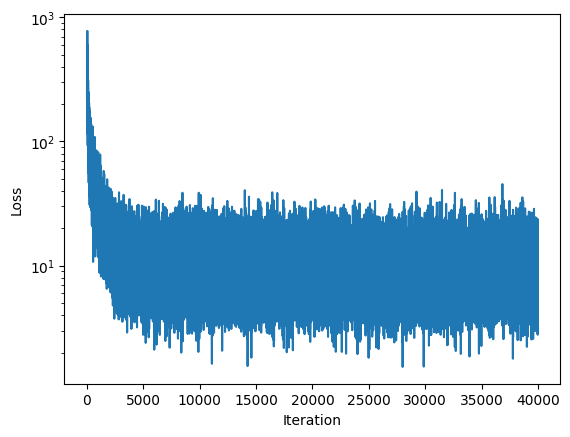

In [ ]:
model_uvfactorization_true_rank = sparse_recovery.SparseRecovery_UVFactorization(
    num_rows,
    num_cols,
    true_rank,
    scale_uv_norm=0.1,
    scale_sparse_norm=50.0,
).train(teacher, ax=plt.gca())

The loss is the squared normed of the predictio nerror, $\|y - \hat{y}\|_2^2/d$. It plateau's at ~6, whereas a loss of 0 is attainable.

The plot below compares the spectrum of $W^*$ against that of $UV^T+S$. It also compares the spectrum of the low-rank component of $W^*$ against that of $UV^T$. These match somewhat.

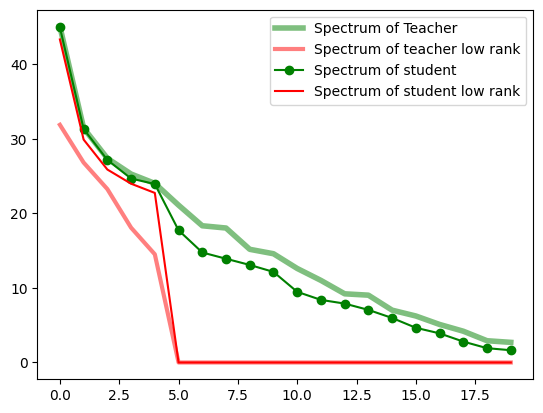

In [4]:
sparse_recovery.plot_spectra(model_uvfactorization_true_rank, teacher)

The plot below compares the content of $W^*$ against that of the recovered $UV^T+S$. It also compares the sparse component of $W^*$ against $S$.

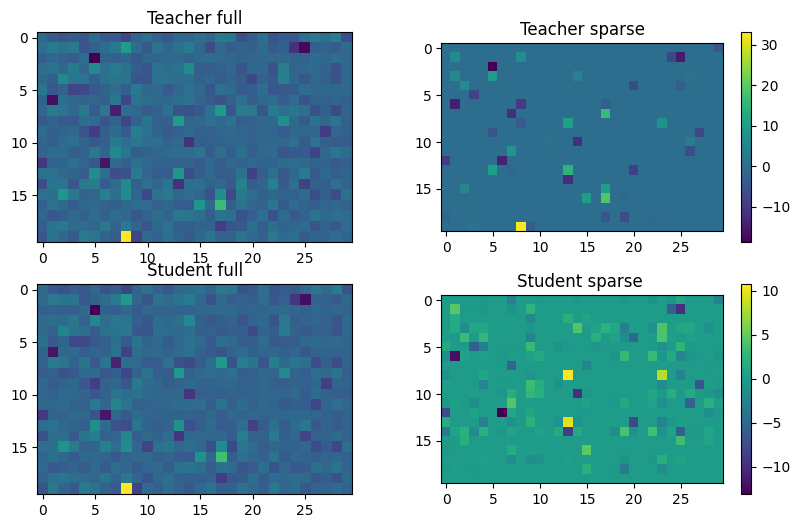

In [5]:
sparse_recovery.show_matrices(model_uvfactorization_true_rank, teacher)

We're indeed able to recover a sparse matrix and the low rank matrix with SGD. But notice that even after tens of thousands of iterations, the loss is not close to 0. The sparse component isn't recovered exactly either, as can be witnessed from the dramatically different scales on the sparse plots. We're not able to fit this model with SGD quite well.

## Automatically discover the rank

Let's take a slight detour to see if we can learn a good value for $r$ automatically. Above, we used the $r$ that generated the training data, a parameter that'll be inaccessible to us in real life.

Penalizing the sum of the Frobenius norms of $U$ and $V$ is the same as penalizing the nuclear norm of $UV^\top$. The nuclear norm of a matrix is the L1 norm of its singular values. Minimizing the nuclear norm therefore reduces the rank of a matrix. Introducing the nuclear norm of $UV^\top$ as a penalty gives SGD the ability to choose a lower rank than $r$ for $UV^\top$ (see [this paper](https://papers.nips.cc/paper_files/paper/2004/file/e0688d13958a19e087e123148555e4b4-Paper.pdf)). Let's see how well this works in practice.

More precisely, we'll use SGD to minimize the following loss:

$$
\mathcal{L}(U,V,S; x,y ) \equiv   \|\left(UV^T + S\right) x - y\|_2^2 + \lambda_1 \|S\|_1  + \lambda_2 \|U\|_F^2 + \lambda_2 \|V\|_F^2
$$

Here, $U$ is $d_1 \times d_1$ and $V$ is $d_1 \times d_2$. The hope is that SGD will make most of their rows linearly dependent so that $UV^T$ has low rank.

Final loss: 6.9366278648376465


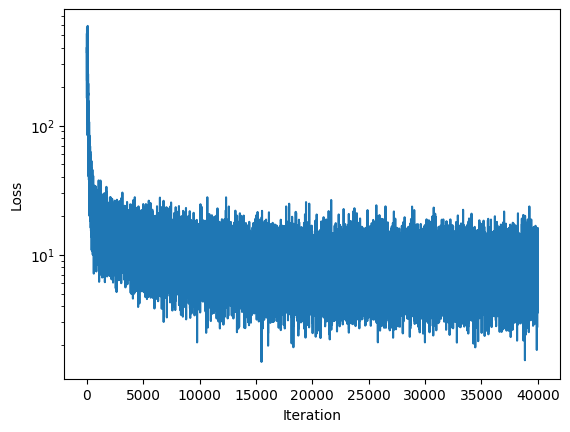

In [15]:
model_uvfactorization = sparse_recovery.SparseRecovery_UVFactorization(
    num_rows, num_cols, num_rows, scale_uv_norm=100.0, scale_sparse_norm=50.0
).train(teacher, ax=plt.gca())

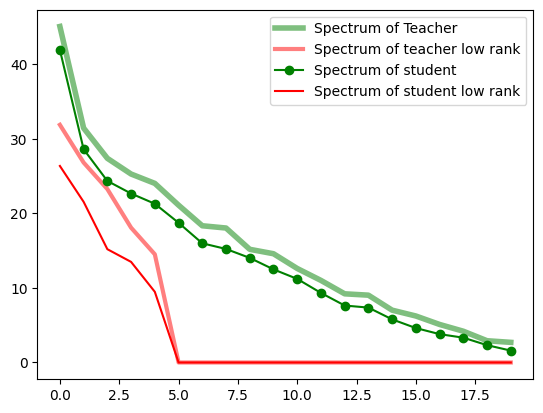

In [16]:
sparse_recovery.plot_spectra(model_uvfactorization, teacher)

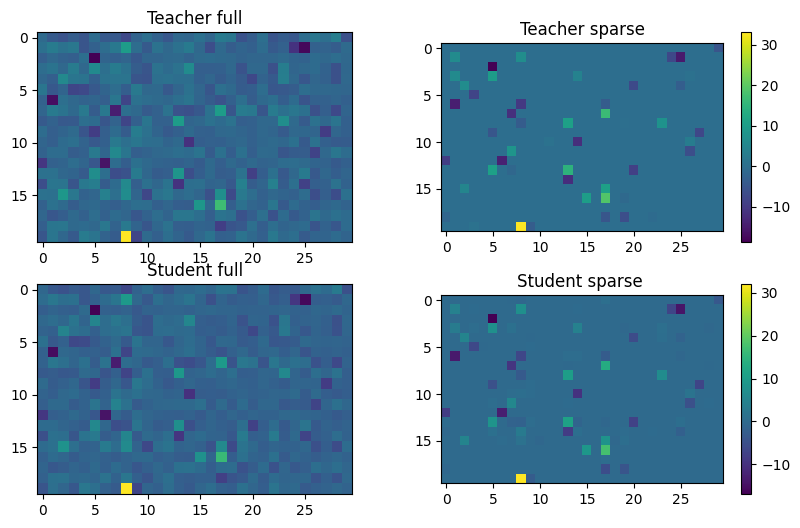

In [8]:
sparse_recovery.show_matrices(model_uvfactorization, teacher)

We started with $r=20$, but SGD found a representation that had rank 11. The true rank was 5, so we didn't find the lowest rank structure possible. We did seem to find the sparse structure of $W^*$ almost exactly, however. The prediction error is also quite large, again however at ~6.

## Represent the low rank component with a dense matrix and penalize with nuclear norm. Minimize with SGD.

Instead of the representation $UV^\top + S$, I'll use the represetnation $Z+S$, and penalize $Z$ the nuclear norm of $Z$, just as we penalize $S$ with an L1 norm.
More precisely, we'll use SGD to minimize the following loss:

$$
\mathcal{L}(Z,S; x,y ) \equiv   \|\left(Z + S\right) x - y\|_2^2 + \lambda_1 \|S\|_1  + \lambda_2 \|Z\|_*.
$$

We'll then recover $U$ and $V$ from a singular value decomposition of $Z$.

Final loss: 0.2698310315608978


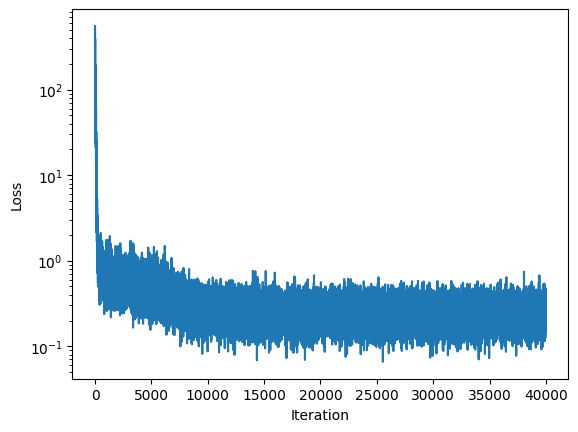

In [17]:
model_nuclearnorm = sparse_recovery.SparseRecovery_NuclearNorm(
    num_rows,
    num_cols,
    scale_low_rank_norm=10.0,
    scale_sparse_norm=10.0,
).train(teacher, learning_rate=0.1, ax=plt.gca())

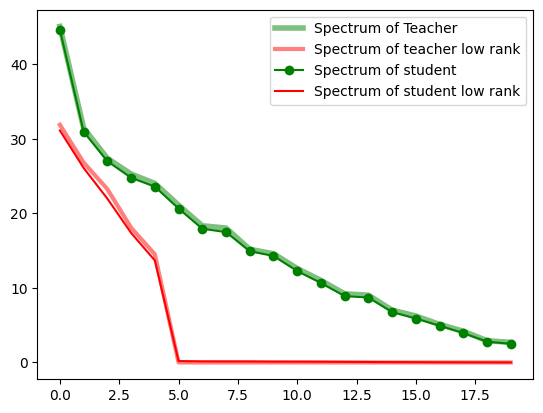

In [18]:
sparse_recovery.plot_spectra(model_nuclearnorm, teacher)

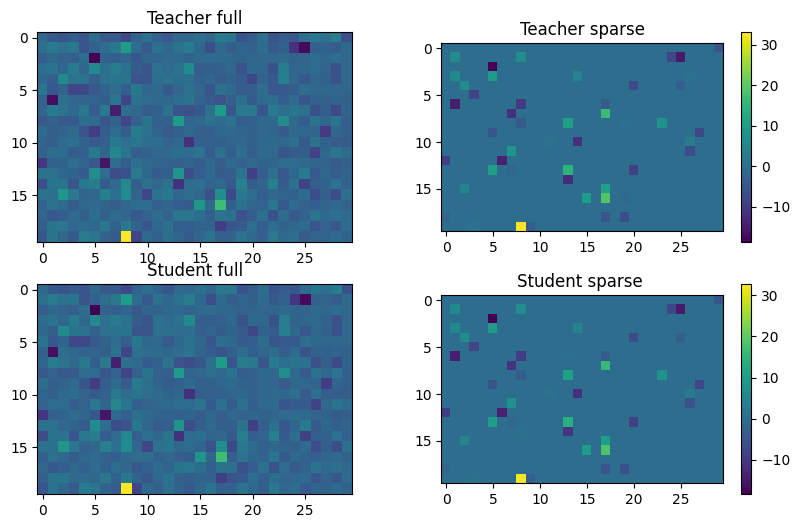

In [19]:
sparse_recovery.show_matrices(model_nuclearnorm, teacher)

This does much better than the previous methods. First, it attains a much lower loss, at ~0.3. Second, it finds the lower rank structure (rank 5). It also finds the sparse structure.

## Represent the low rank component with a dense matrix, penalize its nuclear norm, and minimize with proximal gradient descent

We'll use Prox SGD to minimize the following loss:

$$
\mathcal{L}(Z,S; x,y ) \equiv   \|\left(Z + S\right) x - y\|_2^2 + \lambda_1 \|S\|_1  + \lambda_2 \|Z\|_*.
$$

Final loss: 0.0005897763185203075


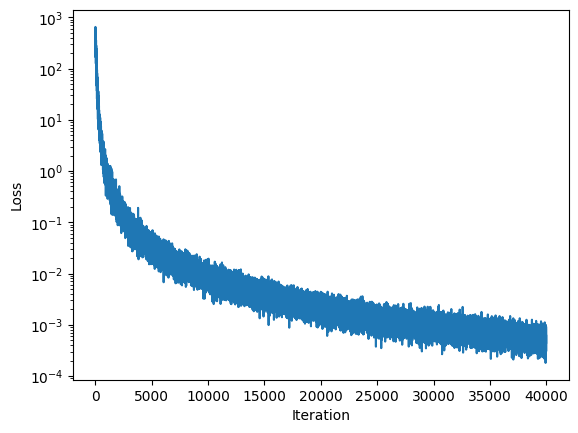

In [ ]:
model_prox = sparse_recovery.SparseRecovery_Proximal(
    num_rows, num_cols, scale_low_rank_norm=100.0, scale_sparse_norm=20.0
).train(teacher, learning_rate=0.1, ax=plt.gca())

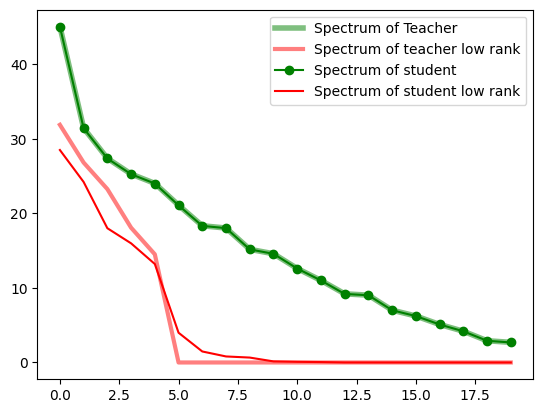

In [13]:
sparse_recovery.plot_spectra(model_prox, teacher)

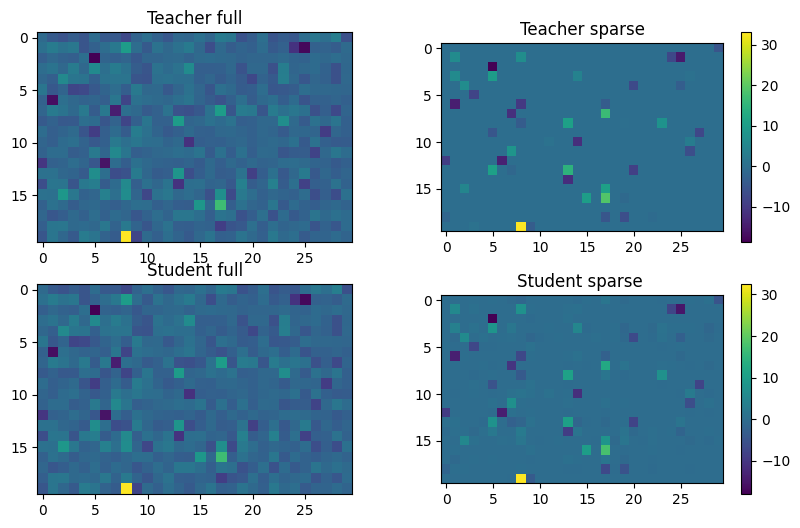

In [14]:
sparse_recovery.show_matrices(model_prox, teacher)

This is by far the best performing algorithm. It attains much lower loss, and it recovers both sparse and low-rank components nearly exactly.